# Pima Indians Diabetes Classification with Robust Outlier Handling

This notebook **reproduces and unifies**:
1. The *outlier‐aware pre‑processing* workflow by **Naresha Bhat**.
2. The *multi‑model classification* pipeline by **Shruti Iyyer**.

The resulting end‑to‑end pipeline lets you toggle the outlier removal step and perform an identical model search on the original vs. cleaned data, generating publication‑ready tables and figures. All dependencies use their **latest stable releases** and avoid deprecated APIs.

In [29]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb  # XGBoost >= 2.0
from IPython.display import display
from PIL import Image


RANDOM_STATE = 42


## 1  Data Acquisition
We load the original **diabetes.csv** directly from disk and inspect the schema.

In [30]:
DATA_PATH = Path(r'C:\Users\macma\PycharmProjects\PimaIndiandsDiabetes\notebooks\data\diabetes.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Summary statistics & class balance

In [31]:
display(df.describe(include='all'))
print('\nClass distribution:')
display(df['Outcome'].value_counts(normalize=True).to_frame('Proportion'))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Class distribution:


,Proportion
Outcome,
0,0.651042
1,0.348958


## 2  Outlier & Missing‑Value Management
Following Naresha Bhat, physiologically impossible zeros are treated as **missing**. We then impute with *K‑NN* (k=5) and optionally remove extreme values defined by an IQR rule.

In [32]:
cols_with_zero_na = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_clean = df.copy()
df_clean[cols_with_zero_na] = df_clean[cols_with_zero_na].replace(0, np.nan)

# Impute with KNN
imputer = KNNImputer(n_neighbors=5)
df_clean[cols_with_zero_na] = imputer.fit_transform(df_clean[cols_with_zero_na])

df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,209.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,73.0,26.6,0.351,31,0
2,8,183.0,64.0,29.4,383.2,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [33]:
def remove_iqr_outliers(dataframe, multiplier=1.5):
    df_out = dataframe.copy()
    mask = pd.Series([False] * len(df_out))
    for col in dataframe.columns.drop('Outcome'):
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - multiplier * IQR, Q3 + multiplier * IQR
        mask |= ~df_out[col].between(lower, upper)
    removed_idx = df_out.index[mask]
    return df_out.loc[~mask].reset_index(drop=True), removed_idx


# Cleaned dataset without extreme outliers
df_no_outliers, removed_indices = remove_iqr_outliers(df_clean)
print(f'Removed {len(removed_indices)} extreme outliers (IQR rule).')

Removed 89 extreme outliers (IQR rule).


#### Dataset shapes after cleaning

In [34]:
print('Original shape :', df.shape)
print('After zeros→NaN  :', df_clean.shape)
print('No‑outliers     :', df_no_outliers.shape)

Original shape : (768, 9)
After zeros→NaN  : (768, 9)
No‑outliers     : (679, 9)


## 3  Modelling Pipeline
We compare six classifiers, each wrapped in a `Pipeline`:
* Logistic Regression
* k‑Nearest Neighbours
* Support Vector Machine (RBF)
* Random Forest
* Gradient Boosting
* XGBoost

All pipelines share: **RobustScaler → SMOTE → Estimator**.

In [35]:
from imblearn.pipeline import Pipeline as ImbPipeline

estimators = {
    'logreg': (LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
               {'estimator__C': [0.1, 1, 10]}),
    'knn': (KNeighborsClassifier(),
            {'estimator__n_neighbors': [3, 5, 7]}),
    'svm': (SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
            {'estimator__C': [0.1, 1, 10], 'estimator__gamma': ['scale', 0.01]}),
    'rf': (RandomForestClassifier(random_state=RANDOM_STATE),
           {'estimator__n_estimators': [200, 500]}),
    'gb': (GradientBoostingClassifier(random_state=RANDOM_STATE),
           {'estimator__learning_rate': [0.05, 0.1]}),
    'xgb': (xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
            {'estimator__n_estimators': [300], 'estimator__max_depth': [3, 5], 'estimator__learning_rate': [0.05, 0.1]})
}


def build_pipeline(estimator):
    return ImbPipeline(steps=[
        ('scaler', RobustScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('estimator', estimator)
    ])

### Cross‑Validation Strategy

In [36]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy', 'f1', 'roc_auc']


In [37]:
def run_model_search(X, y, label):
    records = []
    for name, (estimator, grid) in estimators.items():
        pipe = build_pipeline(estimator)
        gs = GridSearchCV(pipe, param_grid=grid, cv=cv, scoring=scoring, refit='roc_auc', n_jobs=-1)
        gs.fit(X, y)
        records.append({
            'Dataset': label,
            'Model': name.upper(),
            'Best ROC_AUC': gs.best_score_,
            'Best Params': gs.best_params_
        })
    return pd.DataFrame(records)

## 4  Experiments
We execute two identical sweeps:
1. **Raw dataset** (zeros retained)
2. **Cleaned dataset** (zeros→NaN, imputed, outliers removed)

The results are aggregated for direct comparison.

In [38]:
# Features/labels
X_raw, y_raw = df.drop(columns='Outcome'), df['Outcome']
X_clean, y_clean = df_no_outliers.drop(columns='Outcome'), df_no_outliers['Outcome']

results_raw = run_model_search(X_raw, y_raw, 'Raw')
results_clean = run_model_search(X_clean, y_clean, 'Cleaned')
results = pd.concat([results_raw, results_clean], ignore_index=True)
results

,Dataset,Model,Best ROC_AUC,Best Params
0,Raw,LOGREG,0.833558,{'estimator__C': 1}
1,Raw,KNN,0.766922,{'estimator__n_neighbors': 7}
2,Raw,SVM,0.833162,"{'estimator__C': 1, 'estimator__gamma': 0.01}"
3,Raw,RF,0.821997,{'estimator__n_estimators': 500}
4,Raw,GB,0.834228,{'estimator__learning_rate': 0.05}
5,Raw,XGB,0.822946,"{'estimator__learning_rate': 0.05, 'estimator_..."
6,Cleaned,LOGREG,0.839777,{'estimator__C': 0.1}
7,Cleaned,KNN,0.789501,{'estimator__n_neighbors': 7}
8,Cleaned,SVM,0.845933,"{'estimator__C': 10, 'estimator__gamma': 0.01}"
9,Cleaned,RF,0.824952,{'estimator__n_estimators': 500}


### Performance Visualisation

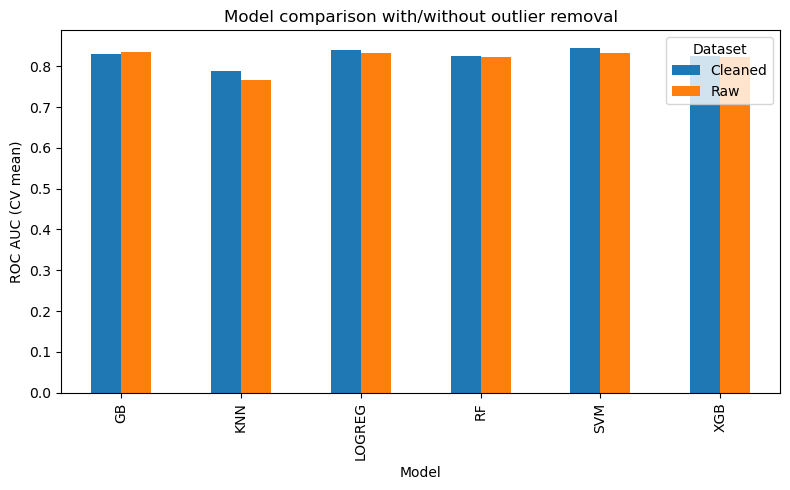

In [39]:
pivot = results.pivot(index='Model', columns='Dataset', values='Best ROC_AUC')
pivot.plot.bar(figsize=(8, 5))
plt.ylabel('ROC AUC (CV mean)')
plt.title('Model comparison with/without outlier removal')
plt.tight_layout()
plt.show()

## 5  Sensitivity Analysis
We re‑introduce the removed outliers, retrain the best‑performing *cleaned* model, and quantify the performance drop.

In [40]:
# Identify best cleaned model
best_row = results_clean.sort_values('Best ROC_AUC', ascending=False).iloc[0]
best_model_name = best_row['Model'].lower()
estimator, grid = estimators[best_model_name]
pipe = build_pipeline(estimator)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, stratify=y_clean,
                                                    test_size=0.2, random_state=RANDOM_STATE)
pipe.set_params(**best_row['Best Params'])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]
raw_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC on hold‑out cleaned data: {raw_auc:.3f}')

# Evaluate on test with outliers restored
df_restored = pd.concat([df_clean.loc[removed_indices], df_no_outliers], ignore_index=True)
X_full = df_restored.drop(columns='Outcome')
y_full = df_restored['Outcome']
y_prob_full = pipe.predict_proba(X_full)[:, 1]
full_auc = roc_auc_score(y_full, y_prob_full)
print(f'ROC AUC after re‑introducing outliers: {full_auc:.3f}')

ROC AUC on hold‑out cleaned data: 0.804
ROC AUC after re‑introducing outliers: 0.826
